### 간단한 패턴 만들기

In [1]:
import torch
import random

# real 이미지 생성 함수
def generate_real():
    #random.uniform(a,b) a~b 랜덤실수
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])

    return real_data

In [2]:
# random 이미지 생성 함수

def generate_random(size):
    # 평균 0, 표준편차 1인 정규분포 난수 생성
    random_data = torch.rand(size)

    return random_data

In [3]:
import torch.nn as nn
import pandas as pd

# 판별모형
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
   
        self.model = nn.Sequential(
            nn.Linear(4, 3),
#                     in
            nn.Sigmoid(),
            nn.Linear(3, 1),
#                        out
            nn.Sigmoid()
        )

        self.loss_function = nn.MSELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):

        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

In [4]:
D = Discriminator()

for i in range(10000):
    # real image
    D.train(generate_real(), torch.FloatTensor([1.0]))

    # fake image
    D.train(generate_random(4), torch.FloatTensor([0.0])) 

counter =  10000
counter =  20000


In [5]:
print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.8234145045280457
0.03992564231157303


In [6]:
# 생성모형
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 3),
#                     in
            nn.Sigmoid(),
            nn.Linear(3, 4),
#                        out
            nn.Sigmoid()
        )
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []    

    def forward(self, inputs):        

        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)    
        loss = D.loss_function(d_output, targets)
        self.counter += 1

        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

In [7]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5593, 0.4949, 0.5183, 0.4246], grad_fn=<SigmoidBackward0>)

In [8]:
D = Discriminator()
G = Generator()

image_list = []

for i in range(10000):
    # 판별모형 학습(true)    
    D.train(generate_real(), torch.FloatTensor([1.0]))

    # 판별모형 학습(false)
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

    # 생성모형 학습
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    if i % 1000 == 0:
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

counter =  10000
counter =  20000


In [9]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9342, 0.0471, 0.9506, 0.0334], grad_fn=<SigmoidBackward0>)

In [10]:
# 생성된 패턴

image_list

[array([0.48337558, 0.4511192 , 0.3151789 , 0.64215195], dtype=float32),
 array([0.4941517 , 0.44951302, 0.30766279, 0.6343487 ], dtype=float32),
 array([0.5147534 , 0.43589014, 0.30915922, 0.60583884], dtype=float32),
 array([0.5644409 , 0.39573327, 0.33692697, 0.5269018 ], dtype=float32),
 array([0.6589409 , 0.30907145, 0.43887788, 0.35586682], dtype=float32),
 array([0.76372546, 0.20105627, 0.6450531 , 0.18177626], dtype=float32),
 array([0.83574706, 0.12712292, 0.81034195, 0.09921265], dtype=float32),
 array([0.8788539 , 0.0880161 , 0.8857287 , 0.06476437], dtype=float32),
 array([0.9053626 , 0.06692274, 0.9208391 , 0.04809126], dtype=float32),
 array([0.92250913, 0.05468135, 0.93950886, 0.03890513], dtype=float32)]

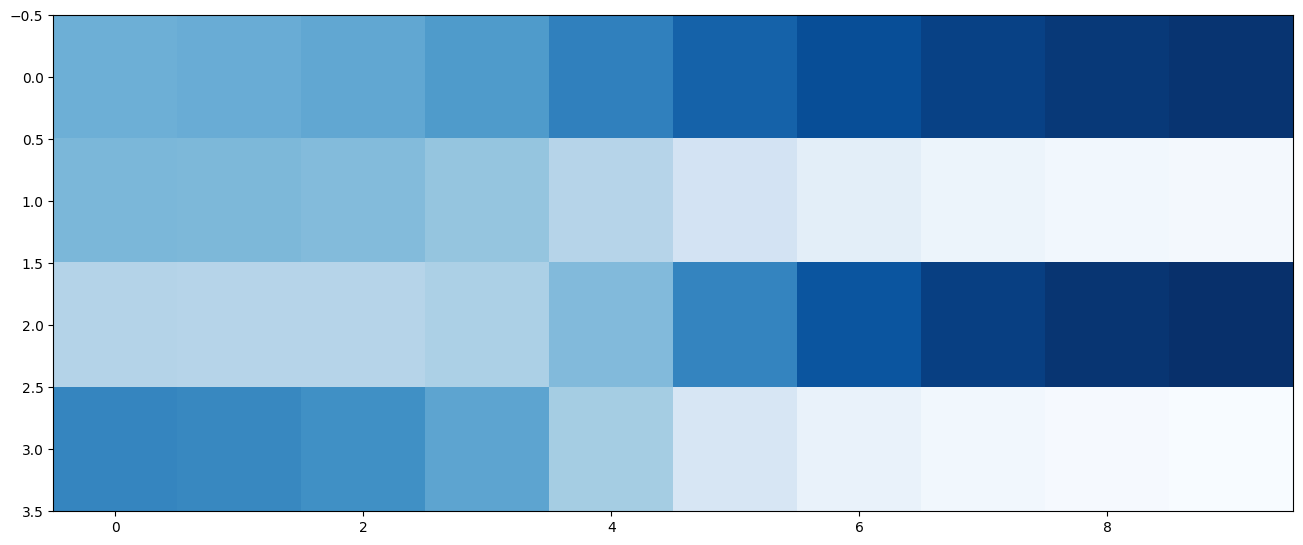

In [14]:
import matplotlib.pyplot as plt
import os    

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np

plt.figure(figsize = (16,8))
plt.imshow(np.array(image_list).T, interpolation='none', cmap='Blues')

plt.show()